<a href="https://colab.research.google.com/github/ColoAlfa/PracticaTesting/blob/master/TextClassification_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Text classification project done by Didac Colominas Abalde, a student at the EPS of the UDL in the field of computing.



# **INTRODUCTION TO THE PROJECT**
This notebook trains a sentiment analysis model to classify movie reviews as positive or negative, depending on the text of the review. This type of analysis is called binary classification, or two-class.

In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

#Comprobamos que version tenemos de tensorflow
print(tf.__version__)

2.5.0


# **STRUCTURE OF DATASET**
Now we will proceed to download and view the DATASET. The set has both positive and negative reviews, and it is balanced in such a way that it has the same positive as negative.


> We proceed to download the DATASET



In [2]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

84131840/84125825 [==============================] - 1s 0us/step




> Now we will see the structure of the dataset:



In [3]:
os.listdir(dataset_dir)


['train', 'imdbEr.txt', 'README', 'imdb.vocab', 'test']

In [4]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['urls_neg.txt',
 'unsupBow.feat',
 'unsup',
 'pos',
 'neg',
 'urls_unsup.txt',
 'labeledBow.feat',
 'urls_pos.txt']



The positive reviews are in the directory aclImdb/train/pos and the negatives are in aclImdb/train/neg. I will open a random review.




In [5]:
sample_file = os.path.join(train_dir, 'pos/0_9.txt')
with open(sample_file) as f:
  print(f.read())

Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as "Teachers". My 35 years in the teaching profession lead me to believe that Bromwell High's satire is much closer to reality than is "Teachers". The scramble to survive financially, the insightful students who can see right through their pathetic teachers' pomp, the pettiness of the whole situation, all remind me of the schools I knew and their students. When I saw the episode in which a student repeatedly tried to burn down the school, I immediately recalled ......... at .......... High. A classic line: INSPECTOR: I'm here to sack one of your teachers. STUDENT: Welcome to Bromwell High. I expect that many adults of my age think that Bromwell High is far fetched. What a pity that it isn't!


# **DATASET**
Next we will prepare the data format to be able to train. For this we will use:


# tf.keras.preprocessing.text_dataset_from_directory:
Basically what it does is generate a dataset already mounted and ready to use.
For this, the directory structure must be:










```
main_directory/
...class_a/
......a_text_1.txt
......a_text_2.txt
...class_b/
......b_text_1.txt
......b_text_2.txt
```



Therefore, we must eliminate all those directories that are not aclImdb / train / pos and aclImdb / train / neg, which are the two possible classes.

In [6]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

Now we can use text_dataset_from_directory to create a tractable dataset. It is recommended to have 3 subsets of data: **TRAINING**,  **VALIDATION**  and **TEST** .

* **Training** : Subset of data used to train the model.
* **Validation** : Subset of data used to adjust hyperparameters. It would be like adjusting the dividing line.
* **Test** : Subset that is passed when the training and validation test has already been passed,

But IMDB lacks a validation set, so we will use the validation_split function. We will take the 25,000 of training, and we will take 80% for a new training pack called "training".



In [7]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)


Found 25000 files belonging to 2 classes.
Using 20000 files for training.


Now we will take the remaining in the "train" folder for validation. I will already define the test ones.

In [8]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [9]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


#**STANDARDIZE DATA FOR TRAINING**
Standardization refers to removing punctuation or HTML elements to simplify the data set. There are two important terms:



*   Tokenization: Separate a phrase, for example, into words (spaces).
*   Vectorization: converting the tokens into numbers to be able to enter the neural network.





Now we are going to on the one hand minimize the text, and eliminate the HTML code. The function below what it will do is replace the "br />" by spaces " "

In [10]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ',)
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

Now we are going to proceed with Vectorization, for this we will use the imported TextVectorization method. Set an "output_mode" to give each token integer values. And then we will call "adapt" which will adapt the data set, making the model create an index of strings to integers.

In [11]:
max_features = 10000
sequence_length = 250

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)
#train_text = [tf.keras.preprocessing.text.one_hot(d, 50) for d in data_x]
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))


train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

Review tf.Tensor(b'Silent Night, Deadly Night 5 is the very last of the series, and like part 4, it\'s unrelated to the first three except by title and the fact that it\'s a Christmas-themed horror flick.<br /><br />Except to the oblivious, there\'s some obvious things going on here...Mickey Rooney plays a toymaker named Joe Petto and his creepy son\'s name is Pino. Ring a bell, anyone? Now, a little boy named Derek heard a knock at the door one evening, and opened it to find a present on the doorstep for him. Even though it said "don\'t open till Christmas", he begins to open it anyway but is stopped by his dad, who scolds him and sends him to bed, and opens the gift himself. Inside is a little red ball that sprouts Santa arms and a head, and proceeds to kill dad. Oops, maybe he should have left well-enough alone. Of course Derek is then traumatized by the incident since he watched it from the stairs, but he doesn\'t grow up to be some killer Santa, he just stops talking.<br /><br />T

Now we have changed every token for an integer, in case we want to get the string we have the function .get_vocabulary() for get the string again.
*`print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])`* That will be Silent.

# **OPTIMIZATION FOR INPUT/OUTPUT**
We are going to implement some methods for avoid that the Input and Output freezes. 


*   .cache(): Keep the data on memory after this are upload outside the disk, this prevent the bottle neck.

* .prefech(): overlap the preprocedure and the exectution of the model.




In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# **CREATING THE MODEL**
Let's create the neuronal netword.


In [13]:
embedding_dim = 16

model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160016    
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


Embedding what does is for every single int representing a word, creates an embedding vector this vector helps to give us the idea of similar meanings. Because we use dropout we will need a lose function, and this will generete a probability. 

In [14]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

Now we will train the model.

In [15]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 11s 16ms/step - loss: 0.6636 - binary_accuracy: 0.6934 - val_loss: 0.6148 - val_binary_accuracy: 0.7754
Epoch 2/10
625/625 [==============================] - 4s 7ms/step - loss: 0.5494 - binary_accuracy: 0.7997 - val_loss: 0.4987 - val_binary_accuracy: 0.8228
Epoch 3/10
625/625 [==============================] - 4s 7ms/step - loss: 0.4461 - binary_accuracy: 0.8450 - val_loss: 0.4202 - val_binary_accuracy: 0.8472
Epoch 4/10
625/625 [==============================] - 4s 6ms/step - loss: 0.3788 - binary_accuracy: 0.8650 - val_loss: 0.3739 - val_binary_accuracy: 0.8602
Epoch 5/10
625/625 [==============================] - 4s 6ms/step - loss: 0.3356 - binary_accuracy: 0.8790 - val_loss: 0.3448 - val_binary_accuracy: 0.8676
Epoch 6/10
625/625 [==============================] - 4s 6ms/step - loss: 0.3050 - binary_accuracy: 0.8875 - val_loss: 0.3258 - val_binary_accuracy: 0.8718
Epoch 7/10
625/625 [==============================] - 4s 7ms/s

In [16]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 8s 11ms/step - loss: 0.3098 - binary_accuracy: 0.8740
Loss:  0.3098066747188568
Accuracy:  0.873960018157959


Because *model.fit()* returns an History Object, we can show a graphic with the training and the validations for compare

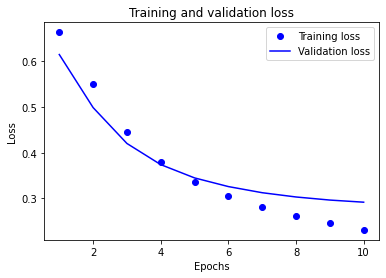

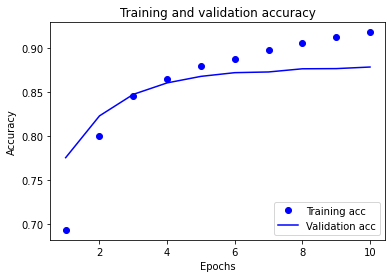

In [17]:
history_dict = history.history
history_dict.keys()

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

#FOR THE ACCURACITY

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()
